<a href="https://colab.research.google.com/github/lin3372/600_graph_neural_net/blob/main/books/Graph_Machine_Learning/03_02_Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

### gpu

In [1]:
!nvidia-smi

Sat Jan  8 18:25:39 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


### directory setting

In [3]:
WORKING_DATA_DIR="./log/data_0302/"

### check and mount google drive

In [4]:
import os, sys
if 'google.colab' in sys.modules:
  print("Running in Google Colab, mounting GDrive")
  from google.colab import drive
  drive.mount('/gdrive')
  WORKING_DATA_DIR = "/gdrive/MyDrive/github/600_graph_neural_net/books/Graph_Machine_Learning/log/data_0302/"
  os.makedirs(WORKING_DATA_DIR, exist_ok=True)


Running in Google Colab, mounting GDrive
Mounted at /gdrive


## set timer

In [5]:
from datetime import datetime

start = datetime.now()


# AutoEncoder 

In the following we will show you how to create, train and use a simple autoencoder. We will then show you how to make an auto-encoder more robust against noise. 

### Load Dataset

In [6]:
import tensorflow as tf

In [7]:
from tensorflow.keras.datasets import fashion_mnist

In [8]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [9]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print (x_train.shape)
print (x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [10]:
from matplotlib import pyplot as plt

In [11]:
classes = {
    0:"T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot", 
}

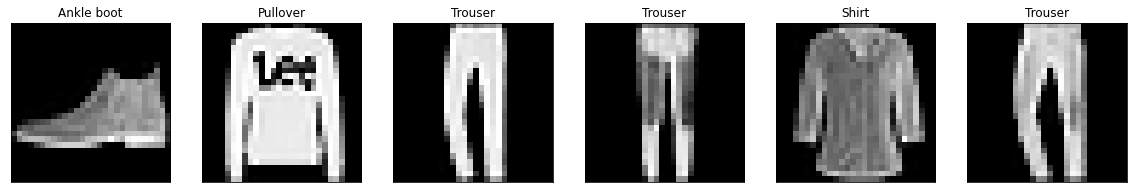

save .... /gdrive/MyDrive/github/600_graph_neural_net/books/Graph_Machine_Learning/log/data_0302/TrainingSet.png


<Figure size 432x288 with 0 Axes>

In [12]:
n = 6
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(x_test[i])
    plt.title(classes[y_test[i]])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()
file_trainingSetPng = WORKING_DATA_DIR + "TrainingSet.png"
plt.savefig(file_trainingSetPng)
print(f"save .... {file_trainingSetPng}")

### Create Autoencoder

In [13]:
from tensorflow.keras.layers import Flatten, Conv2D, Dropout, MaxPooling2D, UpSampling2D, Input

In [14]:
from tensorflow.keras import Model

In [15]:
input_img = Input(shape=(28, 28, 1))

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)

In [16]:
Model(input_img, encoded).summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 8)          0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 8)           584 

In [17]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [18]:
from tensorflow.keras.callbacks import TensorBoard

In [19]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir=WORKING_DATA_DIR + '/tmp/autoencoder')])


Epoch 1/50
469/469 [==============================] - 16s 14ms/step - loss: 0.3513 - val_loss: 0.3138
Epoch 2/50
469/469 [==============================] - 6s 12ms/step - loss: 0.3056 - val_loss: 0.3030
Epoch 3/50
469/469 [==============================] - 5s 12ms/step - loss: 0.2983 - val_loss: 0.2979
Epoch 4/50
469/469 [==============================] - 6s 12ms/step - loss: 0.2944 - val_loss: 0.2950
Epoch 5/50
469/469 [==============================] - 6s 12ms/step - loss: 0.2920 - val_loss: 0.2932
Epoch 6/50
469/469 [==============================] - 5s 11ms/step - loss: 0.2904 - val_loss: 0.2923
Epoch 7/50
469/469 [==============================] - 6s 12ms/step - loss: 0.2892 - val_loss: 0.2910
Epoch 8/50
469/469 [==============================] - 5s 12ms/step - loss: 0.2882 - val_loss: 0.2897
Epoch 9/50
469/469 [==============================] - 6s 12ms/step - loss: 0.2873 - val_loss: 0.2893
Epoch 10/50
469/469 [==============================] - 5s 12ms/step - loss: 0.2865 - val_l

In [20]:
autoencoder.save(WORKING_DATA_DIR + "./Batch50.p")


INFO:tensorflow:Assets written to: /gdrive/MyDrive/github/600_graph_neural_net/books/Graph_Machine_Learning/log/data_0302/./Batch50.p/assets


In [21]:
from tensorflow.keras.models import load_model

In [22]:
autoencoder_first = load_model(WORKING_DATA_DIR + "./Batch50.p")

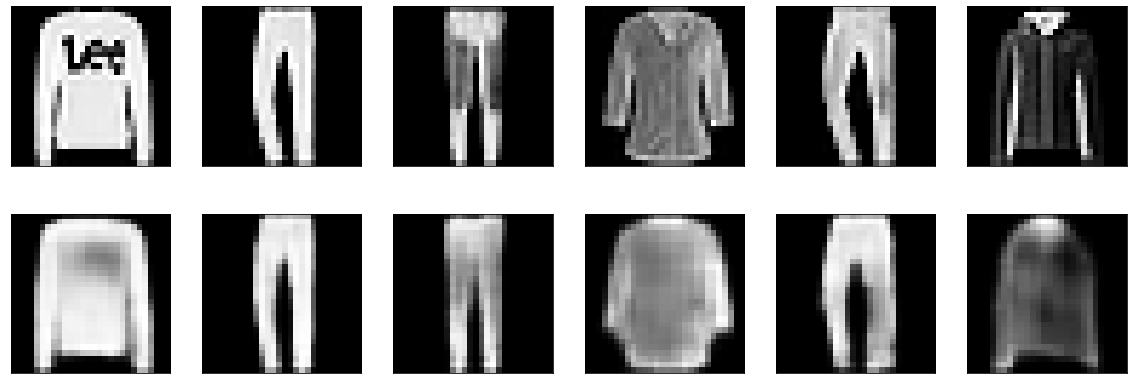

In [23]:
decoded_imgs = autoencoder_first.predict(x_test)

n = 6
plt.figure(figsize=(20, 7))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [24]:
from tensorflow.keras.optimizers import Adam

In [25]:
autoencoder.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy')

In [26]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir=WORKING_DATA_DIR + '/tmp/autoencoder')])

Epoch 1/50
469/469 [==============================] - 7s 13ms/step - loss: 0.2771 - val_loss: 0.2790
Epoch 2/50
469/469 [==============================] - 6s 12ms/step - loss: 0.2769 - val_loss: 0.2790
Epoch 3/50
469/469 [==============================] - 6s 13ms/step - loss: 0.2768 - val_loss: 0.2790
Epoch 4/50
469/469 [==============================] - 6s 12ms/step - loss: 0.2768 - val_loss: 0.2788
Epoch 5/50
469/469 [==============================] - 6s 12ms/step - loss: 0.2768 - val_loss: 0.2788
Epoch 6/50
469/469 [==============================] - 6s 12ms/step - loss: 0.2767 - val_loss: 0.2787
Epoch 7/50
469/469 [==============================] - 6s 12ms/step - loss: 0.2766 - val_loss: 0.2789
Epoch 8/50
469/469 [==============================] - 6s 12ms/step - loss: 0.2766 - val_loss: 0.2786
Epoch 9/50
469/469 [==============================] - 6s 12ms/step - loss: 0.2766 - val_loss: 0.2787
Epoch 10/50
469/469 [==============================] - 6s 12ms/step - loss: 0.2765 - val_lo

In [27]:
autoencoder.save(WORKING_DATA_DIR + "./Batch100.p")

INFO:tensorflow:Assets written to: /gdrive/MyDrive/github/600_graph_neural_net/books/Graph_Machine_Learning/log/data_0302/./Batch100.p/assets


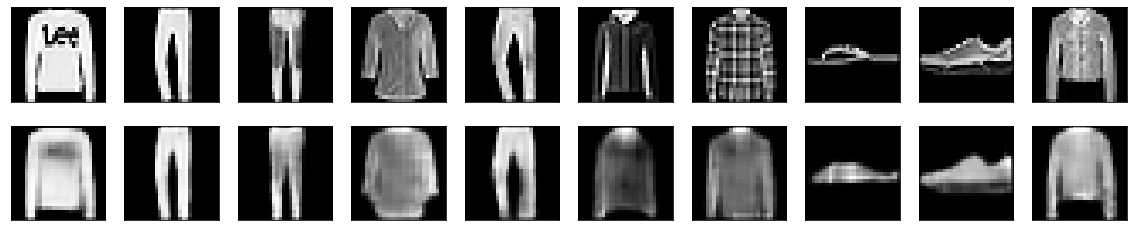

In [28]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

### Embeddings

We use the trained layers in order to get the core representation in the middle layer of the autoencoder, and we represent them with the TSNE

In [29]:
embeddings = Model(input_img, Flatten()(encoded)).predict(x_test)

In [30]:
from sklearn.manifold import TSNE
import numpy as np

In [31]:
tsne = TSNE(n_components=2)

In [32]:
emb2d = tsne.fit_transform(embeddings)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [33]:
x,y = np.squeeze(emb2d[:, 0]), np.squeeze(emb2d[:, 1])

In [34]:
import pandas as pd

In [35]:
from matplotlib.cm import tab10

(-92.16189613342286, 88.00540962219239, -94.51140556335449, 95.83695945739746)

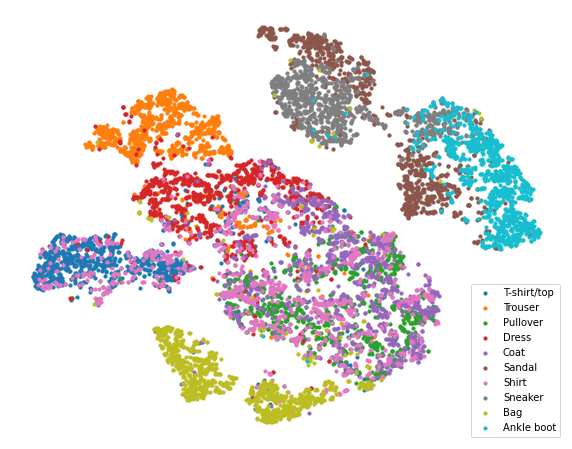

In [36]:
summary =  pd.DataFrame({"x": x, "y": y, "target": y_test, "size": 10})

plt.figure(figsize=(10,8))

for key, sel in summary.groupby("target"):
    plt.scatter(sel["x"], sel["y"], s=10, color=tab10.colors[key], label=classes[key])
    
plt.legend()
plt.axis("off")

### Denoising

Introducing noise in order to train more robust auto-encoders

In [37]:
from tensorflow.keras.layers import GaussianNoise

In [38]:
input_img = Input(shape=(28, 28, 1))

noisy_input = GaussianNoise(0.1)(input_img)

x = Conv2D(16, (3, 3), activation='relu', padding='same')(noisy_input)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

noisy_autoencoder = Model(input_img, decoded)

In [39]:
noisy_autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [40]:
noisy_autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir=WORKING_DATA_DIR + '/tmp/noisy_autoencoder')])

Epoch 1/50
469/469 [==============================] - 7s 14ms/step - loss: 0.3558 - val_loss: 0.3149
Epoch 2/50
469/469 [==============================] - 6s 12ms/step - loss: 0.3053 - val_loss: 0.3039
Epoch 3/50
469/469 [==============================] - 5s 11ms/step - loss: 0.2996 - val_loss: 0.3000
Epoch 4/50
469/469 [==============================] - 5s 11ms/step - loss: 0.2967 - val_loss: 0.2977
Epoch 5/50
469/469 [==============================] - 6s 12ms/step - loss: 0.2946 - val_loss: 0.2949
Epoch 6/50
469/469 [==============================] - 5s 11ms/step - loss: 0.2930 - val_loss: 0.2944
Epoch 7/50
469/469 [==============================] - 6s 12ms/step - loss: 0.2917 - val_loss: 0.2925
Epoch 8/50
469/469 [==============================] - 5s 11ms/step - loss: 0.2907 - val_loss: 0.2920
Epoch 9/50
469/469 [==============================] - 5s 12ms/step - loss: 0.2898 - val_loss: 0.2913
Epoch 10/50
469/469 [==============================] - 6s 12ms/step - loss: 0.2890 - val_lo

In [41]:
autoencoder.save(WORKING_DATA_DIR + "./DenoisingAutoencoder.p")

INFO:tensorflow:Assets written to: /gdrive/MyDrive/github/600_graph_neural_net/books/Graph_Machine_Learning/log/data_0302/./DenoisingAutoencoder.p/assets


In [42]:
noise_factor = 0.1
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

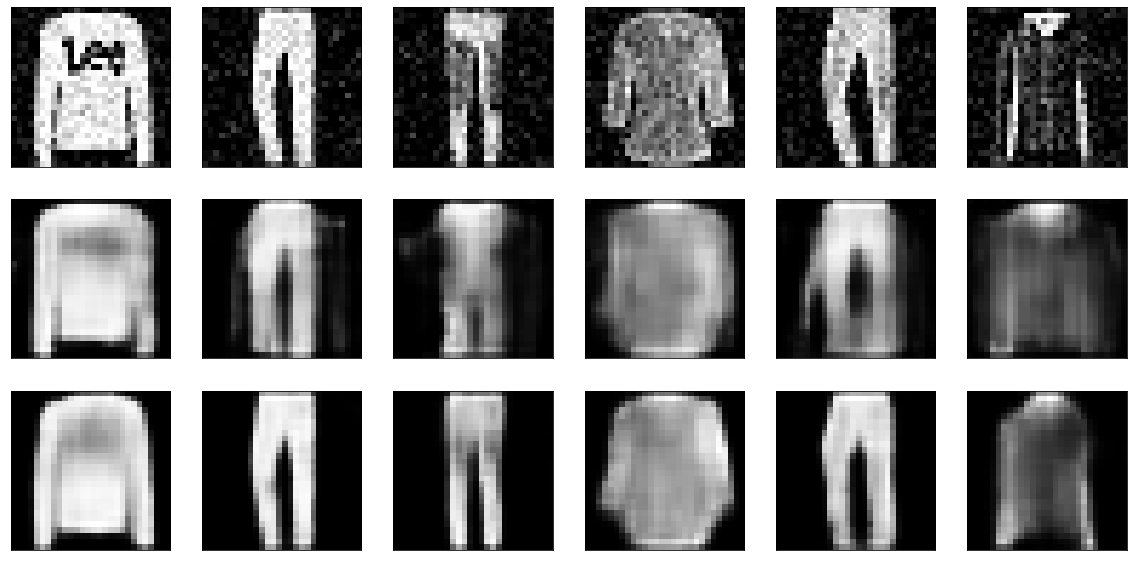

In [43]:
decoded_imgs = autoencoder.predict(x_test_noisy)

decoded_imgs_denoised = noisy_autoencoder.predict(x_test_noisy)

n = 6
plt.figure(figsize=(20, 10))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(3, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    if i==0:
        plt.ylabel("Original")
    else:
        ax.get_yaxis().set_visible(False)
        
    # Display reconstruction
    ax = plt.subplot(3, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    if i==0:
        plt.ylabel("Vanilla Autoencoder")
    else:
        ax.get_yaxis().set_visible(False)
     
    ax = plt.subplot(3, n, i + 2*n)
    plt.imshow(decoded_imgs_denoised[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    if i==0:
        plt.ylabel("Denoising Autoencoder")
    else:
        ax.get_yaxis().set_visible(False)
    
        
plt.show()

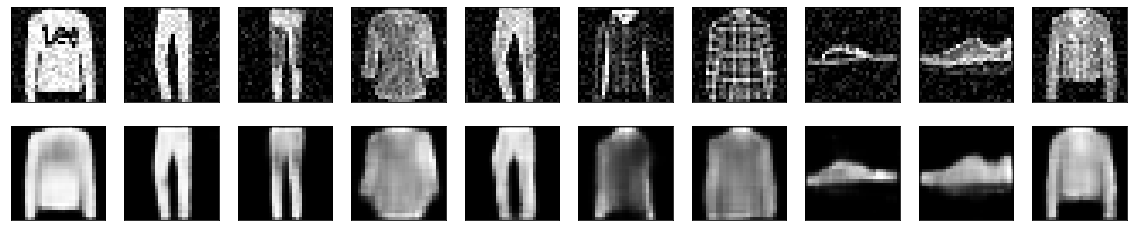

In [44]:
decoded_imgs = noisy_autoencoder.predict(x_test_noisy)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [45]:
print("........03_02_Autoencoders.ipynb Completed ......")
end = datetime.now()

#diff = end - start

# printing the execution time by subtracting
# the time before the function from
# the time after the function
print(end-start)

........03_02_Autoencoders.ipynb Completed ......
0:17:39.433867
